In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie
from source.featlearn.tdr import TDR
from source.torch_utils import getContrastiveFeatures
from source.read_ontario import read_ontario
from source.read_india import read_india
from source.read_brasil import read_brasil
from source.utils import commonWindows
from cuml.manifold import UMAP

import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec
# from cuml.manifold import UMAP

N_VIZ_SAMPLES = 600
VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
MODE = 'shape' # subsequences - shape
EPOCHS = 40
POLLUTANTS = ['CO', 'SO2'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
UMAP_NEIGHBORS = 15



/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
windows_map = read_brasil(granularity='months', cache=True)

windows, dates, station_ids, stations = commonWindows(windows_map, POLLUTANTS)

In [3]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])

stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

mts = TSerie(X=windows, y =station_ids)

mts.smooth(window_size=8)
mts.shapeNormalizization()
# mts.minMaxNormalizization()

Loaded mts - N: 530, T: 28, D: 2 
(530, 2, 28)


In [4]:
from sklearn.decomposition import PCA
class TS2VecModel:
    def __init__(self, output_dims):
        self.output_dims = output_dims
    
    def fit_transform(self, X, n_epochs):
        N, T, D = X.shape
        self.Drepr = np.zeros([N, D, self.output_dims])
        self.Trepr = np.zeros([N, D, T, self.output_dims])
        for i in range(D):
            model = TS2Vec(
                input_dims=1,
                device=0,
                output_dims=self.output_dims,
                
            )
            Xi = np.expand_dims(X[:, :, i], axis=2)
            model.fit(Xi, verbose=True,n_epochs = n_epochs)
            self.Drepr[:, i, :] =  model.encode(Xi, encoding_window='full_series')
            self.Trepr[:, i, :, :] = model.encode(Xi)
            
        self.Dvals = np.zeros([N, D])
        # self.Tvals = np.zeros([N, D])
        for i in range(D):
            reducer = PCA(n_components=1)
            self.Dvals[:, i] =reducer.fit_transform(self.Drepr[:, i, :]).flatten()
            
        return self.Drepr.reshape([N, D * self.output_dims])


In [5]:
model = TS2VecModel(4)
mts.features = model.fit_transform(mts.X, n_epochs = 10)

Epoch #0: loss=2.537143526655255
Epoch #1: loss=2.607708468581691
Epoch #2: loss=2.5261400865786
Epoch #3: loss=2.459736224376794
Epoch #4: loss=2.5426097205190947
Epoch #5: loss=2.5406863581050527
Epoch #6: loss=2.5613612550677676
Epoch #7: loss=2.506630124467792
Epoch #8: loss=2.4916816552480063
Epoch #9: loss=2.459234360492591
Epoch #0: loss=2.611400929364291
Epoch #1: loss=2.6009869719996597
Epoch #2: loss=2.5637956460316977
Epoch #3: loss=2.5354024677565605
Epoch #4: loss=2.4611926223292495
Epoch #5: loss=2.4592731576977354
Epoch #6: loss=2.4433659820845635
Epoch #7: loss=2.4440786332795112
Epoch #8: loss=2.3662174398248847
Epoch #9: loss=2.3135725151408804


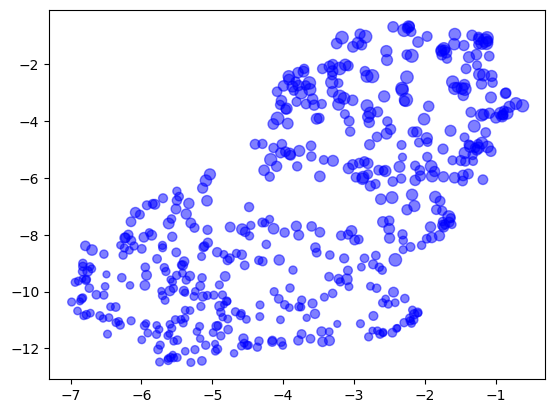

In [6]:
import matplotlib.pyplot as plt

reducer = UMAP(n_components=2, n_epochs=4000)
reducer.fit(mts.features)
coords = reducer.transform(mts.features)
min_r = 10
max_r = 80
magnitudes = mts.magnitudes[:, 0]
point_radius = ((magnitudes + magnitudes.min()) / (magnitudes.max() - magnitudes.min()) ) * (max_r - min_r) + min_r

plt.scatter(coords[:, 0], coords[:, 1], s = point_radius, color="blue", alpha=0.5)



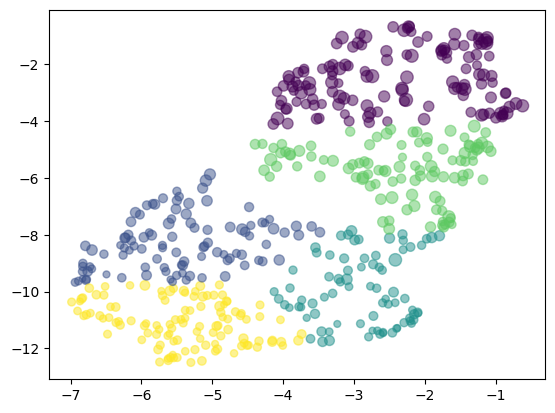

In [7]:
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

classes = kmeans.labels_
# clusters = np.unique(kmeans.labels_)s

# clusterLabels = 

plt.scatter(coords[:, 0], coords[:, 1], s = point_radius, c = classes, alpha=0.5)


In [8]:
from ccpca import CCPCA

groups = np.unique(classes)
group_ids = classes

fcs = []


for target in groups:

    ccpca = CCPCA(n_components=1)
    # target = 2012
    ccpca.fit(
        model.Dvals[group_ids==target],
        model.Dvals[group_ids!=target],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )


    coords2 = ccpca.transform(model.Dvals[group_ids==target])
    # coords2 = ccpca.transform(dfeatures[year_ids!=2011])
    # coords2 = ccpca.transform(dfeatures)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs.append(cpca_fcs)
    # print(cpca_fcs)
    # print(best_alpha)
    # plt.scatter(coords2[:, 0], coords2[:, 1])
# print(len(fcs))
# print(fcs[0].shape)


<BarContainer object of 5 artists>

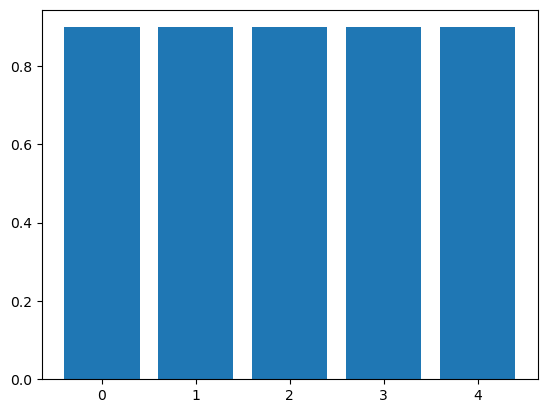

In [11]:
fcs = np.array(fcs)
plt.bar(np.array([i for i in range (n_clusters)]), fcs[:, 0])

<BarContainer object of 5 artists>

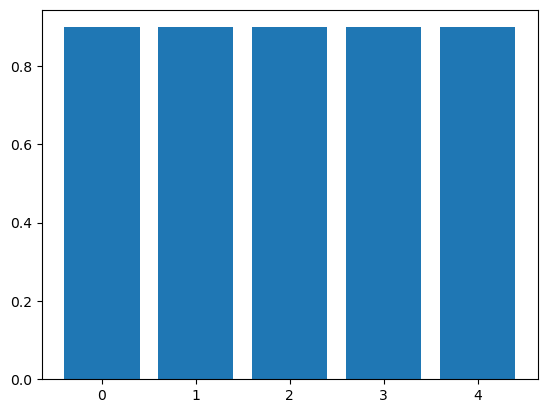

In [12]:
plt.bar(np.array([i for i in range (n_clusters)]), fcs[:, 1])

1999


<BarContainer object of 2 artists>

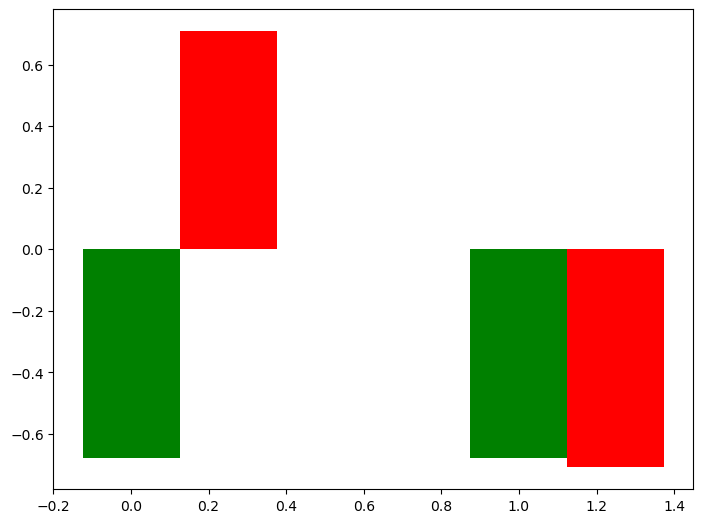

In [ ]:
item1 = 2
item2 = 3
print(year_ids[item2])
fcs = np.array(fcs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.array([i for i in range (2)])
# for i in range(28):
ax.bar(X + 0.00, fcs[item1], color = 'g', width = 0.25)
ax.bar(X + 0.25, fcs[item2], color = 'r', width = 0.25)
# ax.bar(X + 0.50, fcs[:,2], color = 'r', width = 0.25)
# plt.bar(, fcs[:,0])

In [ ]:
from server.source.storage import MTSStorage

storage = MTSStorage(os.path.join(VIS_PATH ,'ts2vec.npy'))    
# storage.delete()
storage.load()

dimensions = POLLUTANTS
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 530 -  T: 28 - D: 4
